In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math
import numdifftools as ndt

# load gas adsorption data

define set of MOFs and gases.

In [2]:
mofs = ["HKUST-1", "Co-MOF-74"]

gases = ["CH4", 
          "N2", 
         "CO2", 
         "C2H6"
        ]

In [3]:
xtal_density = {"HKUST-1" : 879.1, "Co-MOF-74" : 1172.8} # kg/m^3. see compute_density.jl

mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07} # g/mol

gas_to_color = dict(zip(gases, ["C{0}".format(i) for i in range(len(gases))]))

read in `.csv` files containing experimental adsorption data from the literature. see the header of the `.csv` for the data source.

In [4]:
isotherm_data = dict()
for mof in mofs:
    isotherm_data[mof] = dict()
    for gas in gases:
        isotherm_data[mof][gas] = pd.read_csv("data/" + mof + "/" + gas + ".csv", comment='#')

unit conversions. goal:
* loading: mmol gas / g MOF [keep it in mmol for IAST!]
* pressure: bar

In [5]:
# special cases for each MOF
isotherm_data["HKUST-1"]["N2"]["p(bar)"] = isotherm_data["HKUST-1"]["N2"]["p(MPa)"] * 10
isotherm_data["HKUST-1"]["CH4"]["N(mmol/g)"] = isotherm_data["HKUST-1"]["CH4"]["cm3/g"] / 22.4

for gas in ["CH4", "N2", "CO2"]:
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mol/g)"] * 1000.0
    isotherm_data["Co-MOF-74"][gas]["p(bar)"] = isotherm_data["Co-MOF-74"][gas]["p(kPa)"] * 0.01
# where both MOFs need the treatment
for mof in mofs:
    # cm3 STP  *  L STP      *   mol        * 1000mmol
    #  g      1000 cm3 STP    22.4 L STP       1 mol

    isotherm_data[mof]["C2H6"]["p(bar)"] = isotherm_data[mof]["C2H6"]["P(mmHg)"] / 750.062
    # cm3 STP  *  L STP      *   mol      * 1000mmol *    m3 MOF    *   kg      * (100^3) cm3 MOF
    # cm3 MOF  1000 cm3 STP   22.4 L STP     1 mol      ρ_MOF kg      1000 g         m3 MOF
    isotherm_data[mof]["C2H6"]["N(mmol/g)"] = isotherm_data[mof]["C2H6"]["N(cm3STP/cm3)"] * 100 ** 3 / 1000 / 22.4 / xtal_density[mof]
    
# check for success
for mof in mofs:
    for gas in gases:
        try:
            isotherm_data[mof][gas]["N(mmol/g)"]
            isotherm_data[mof][gas]["p(bar)"]
        except KeyError:
            print("failed unit conversion! mof = ", mof, "gas = ", gas)

convert to absolute for the Co-MOF-74 data.

In [6]:
V_pore_co_mof_74 = 0.48 # cm3/g from Table S1 here: http://www.rsc.org/suppdata/sc/c3/c3sc51319j/c3sc51319j.pdf

In [7]:
bulk_gas_density = dict() # 298 K
for gas in ["CH4", "N2", "CO2"]:
    bulk_gas_density[gas] = pd.read_csv("data/bulk_gas/" + gas + ".cgi", delimiter="\t") # read .cgi files
    
def rho_bulk(gas, p):
    # https://numpy.org/doc/stable/reference/generated/numpy.interp.html
    return np.interp(p, bulk_gas_density[gas]["Pressure (bar)"], bulk_gas_density[gas]["Density (mol/l)"])

In [8]:
bulk_gas_density["CH4"]["Pressure (bar)"]

,Temperature (K),Pressure (bar),Density (mol/l),Volume (l/mol),Internal Energy (kJ/mol),Enthalpy (kJ/mol),Entropy (J/mol*K),Cv (J/mol*K),Cp (J/mol*K),Sound Spd. (m/s),Joule-Thomson (K/bar),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase
0,298.0,0.0,0.00000,infinite,12.131,14.609,463.420,27.388,35.703,448.70,undefined,11.168,0.034201,vapor
1,298.0,1.0,0.04043,24.734,12.120,14.593,107.170,27.404,35.796,448.37,0.43820,11.181,0.034274,vapor
2,298.0,2.0,0.08100,12.346,12.108,14.577,101.370,27.421,35.889,448.05,0.43766,11.193,0.034341,vapor
3,298.0,3.0,0.12171,8.2162,12.097,14.562,97.958,27.437,35.983,447.73,0.43711,11.205,0.034407,vapor
4,298.0,4.0,0.16256,6.1515,12.085,14.546,95.528,27.453,36.078,447.41,0.43656,11.218,0.034473,vapor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,298.0,146.0,7.19450,0.13900,10.267,12.296,59.897,29.455,54.287,469.08,0.24724,16.164,0.052470,supercritical
149,298.0,147.0,7.24660,0.13800,10.254,12.283,59.806,29.463,54.385,469.90,0.24542,16.220,0.052651,supercritical
150,298.0,148.0,7.29870,0.13701,10.242,12.269,59.715,29.471,54.481,470.73,0.24361,16.276,0.052831,supercritical
151,298.0,149.0,7.35060,0.13604,10.229,12.256,59.625,29.479,54.575,471.57,0.24180,16.332,0.053012,supercritical


In [9]:
a = rho_bulk("CH4", 1.5)
a

0.060715000000000005

In [27]:
# convert vol: mmol/cc = mol/L
for gas in ["CH4", "N2", "CO2"]:
    isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] = isotherm_data["Co-MOF-74"][gas]["N(mmol/g)"] + V_pore_co_mof_74 * rho_bulk(gas, 
                                                                                                                              isotherm_data["Co-MOF-74"][gas]["p(bar)"])

plot raw data

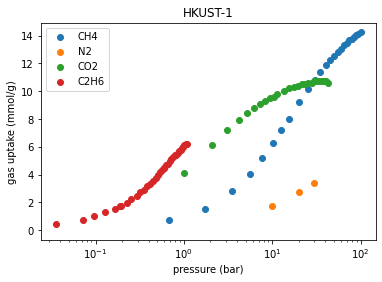

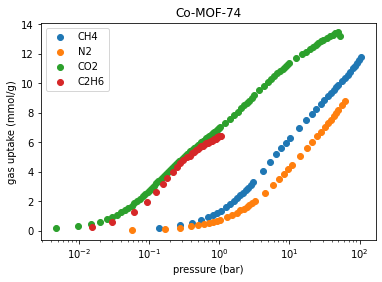

In [28]:
for mof in mofs:
    plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas, color=gas_to_color[gas])
    plt.xscale("log")
    plt.title(mof)
    plt.legend()

# fit isotherm models to data for IAST

In [60]:
isotherms = dict()
for mof in mofs:
    isotherms[mof] = dict()
    for gas in gases:
        model = "Langmuir"
        if mof == "Co-MOF-74" and gas == "C2H6":
            model = "DSLangmuir"
        isotherms[mof][gas] = iast.ModelIsotherm(isotherm_data[mof][gas], 
                                                 loading_key="N(mmol/g)", pressure_key="p(bar)", model=model)

Maximum number of function evaluations has been exceeded.
('\n\tDefault starting guess for parameters:', {'M1': 3.548076577880241, 'K1': 1.0220800309988742, 'M2': 3.548076577880241, 'K2': 1.533120046498311})


Exception: Minimization of RSS for DSLangmuir isotherm fitting
            failed. Try a different starting point in the nonlinear optimization
            by passing a dictionary of parameter guesses, param_guess, to the
            constructor

In [59]:
isotherms["Co-MOF-74"]["C2H6"].params

{'M': 10.516199609074071, 'Ka': 2.869526816810903, 'Kb': -0.388998873068226}

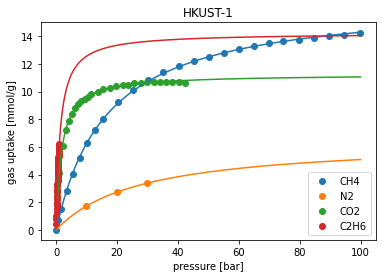

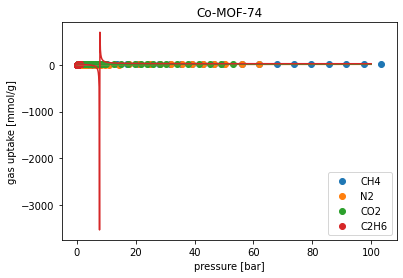

In [56]:
for mof in mofs:
    pressures = np.logspace(-2, 2, 500)
    
    plt.figure()
    for gas in gases:
        plt.scatter(isotherm_data[mof][gas]["p(bar)"], isotherm_data[mof][gas]["N(mmol/g)"], 
                    marker='o', label=gas, color=gas_to_color[gas])
        plt.plot(pressures, isotherms[mof][gas].loading(pressures))
#     plt.xscale("log")
#     plt.xlim([0, 1])
    plt.xlabel("pressure [bar]")
    plt.ylabel("gas uptake [mmol/g]")
    plt.title(mof)
    plt.legend()

# set up single-MOF IAST calculations
to obtain $m(\mathbf{x})$, the total mass adsorbed in a given MOF with composition at pressure $\mathbf{x}$.

In [31]:
p_total = 1.0 # total pressure [bar]

In [32]:
"""
compute *total* mass of adsorbed gas in the MOF.
returns units: g gas / g MOF

# example:
mol_fxns = {'C2H6': 0.4, 'CH4': 0.6}
adsorbed_mass("HKUST-1", mol_fxns)
"""
def adsorbed_mass(mof, mol_fxns):
    # mol fractions must add to 1.0
    if ~ np.isclose(np.sum([x_i for x_i in mol_fxns.values()]), 1.0):
        raise Exception("mol fxns dont add to 1")
    
    pressures = np.array([p_total * x_i for x_i in mol_fxns.values()])
    
    q = iast.iast(pressures, [isotherms[mof][gas] for gas in mol_fxns.keys()], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gas] for j, gas in enumerate(mol_fxns.keys())]) / 1000

# a single-MOF sensor

In [33]:
mof = "HKUST-1"
contaminants = ["C2H6", "CO2"]

In [34]:
"""
convert mol fraction vector with contaminant mole fractions into a mol_fxn dictionary.
"""
def x_to_mol_fxns(x):
    assert len(x) == len(contaminants)
    mol_fxns = dict()
    mol_fxns["CH4"] = 1.0 - np.sum(x)
    for i, contaminant in enumerate(contaminants):
        mol_fxns[contaminant] = x[i]
    return mol_fxns

"""
convert mole fraction dict to x
"""
def mol_fxns_to_x(mol_fxns):
    return np.array([mol_fxns[contaminant] for contaminant in contaminants])

create heapmap to visualize $m(\mathbf{x})$

In [35]:
delta = 0.005
x_1 = np.arange(0.01, 0.3, delta)
x_2 = np.arange(0.01, 0.3, delta)
X_1, X_2 = np.meshgrid(x_1, x_2)
M = np.zeros(np.shape(X_1))
for i in range(np.shape(X_1)[0]):
    for j in range(np.shape(X_2)[1]):
        mol_fxns = x_to_mol_fxns([x_1[i], x_2[j]])
        M[j, i] = adsorbed_mass(mof, mol_fxns)

define operating point about which to linearize, compute adsorbed mass at the operating point.

In [36]:
mol_fxns_op = {"CH4": 0.85, contaminants[0]: 0.05, contaminants[1]: 0.1}
mol_fxns_op

{'CH4': 0.85, 'C2H6': 0.05, 'CO2': 0.1}

In [37]:
x_op = mol_fxns_to_x(mol_fxns_op)
x_op

array([0.05, 0.1 ])

In [38]:
m_op = adsorbed_mass(mof, mol_fxns_op)
m_op

0.05038821853163021

compute Jacobian matrix of $m(\mathbf{x})$.

In [39]:
def jacobian_matrix_of_m(mof, mol_fxns):
    # complicated b/c adsorbed mass takes in a dictionary.
    # construct J(x)
    J = ndt.Jacobian(lambda x: adsorbed_mass(mof, x_to_mol_fxns(x)), step=0.001)
    
    # compute x for given mole fractions
    x = mol_fxns_to_x(mol_fxns)
    return J(x)

# Jacobian at operating point
J_op = jacobian_matrix_of_m(mof, mol_fxns_op)

# right singular vectors
v1, v2 = np.linalg.svd(J_op)[2]

(0.01, 0.295, 0.01, 0.295)

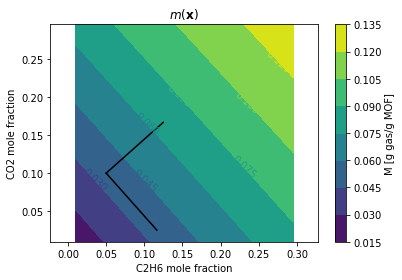

In [40]:
fig, ax = plt.subplots()
CS = ax.contourf(X_1, X_2, M)
plt.colorbar(CS, label="M [g gas/g MOF]")
ax.clabel(CS, inline=True)
ax.set_title("$m(\mathbf{x})$")
ax.set_xlabel(contaminants[0] + " mole fraction")
ax.set_ylabel(contaminants[1] + " mole fraction")
plt.plot([x_op[0], x_op[0] - v1[0]/10], [x_op[1], x_op[1] - v1[1]/10], color='k')
plt.plot([x_op[0], x_op[0] - v2[0]/10], [x_op[1], x_op[1] - v2[1]/10], color='k')
plt.axis("equal")

In [41]:
def V(x, y, z):
    x, y, z = x[0][0], y[0][0], z[0][0]
    print(x, y, z)
    if x + y + z <= 1:
        return adsorbed_mass([1 - x - y - z, x, y, z])
    else:
        return NaN

In [42]:
X, Y, Z = np.mgrid[0.001:0.003:0.999, 0.001:0.003:0.999, 0.001:0.003:0.999]
X, Y, Z

(array([[[0.001]]]), array([[[0.001]]]), array([[[0.001]]]))

In [43]:
V(X, Y, Z)

[0.001] [0.001] [0.001]


TypeError: adsorbed_mass() missing 1 required positional argument: 'mol_fxns'

In [44]:
from mayavi import mlab
mlab.contour3d(X, Y, Z, V)

ImportError: Could not import backend for traitsui.  Make sure you
        have a suitable UI toolkit like PyQt/PySide or wxPython
        installed.

In [ ]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

In [ ]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

In [ ]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

In [ ]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

In [ ]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")